In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.linalg import expm, logm
from numpy.linalg import matrix_power


from edesign import *
from utility import *
from models import *
from edesign import *
from display import *

#setup autoreload
%load_ext autoreload
%autoreload 2

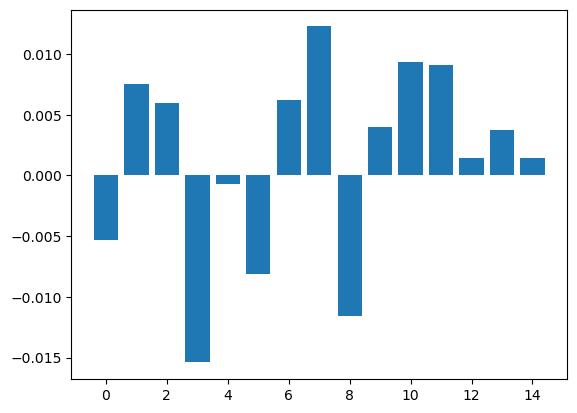

In [2]:
model = UnitaryGateSetModel_CZOnly()
xvec = 0.01*np.random.randn(15)
plt.bar(range(15), xvec)
plt.show()


In [3]:
germs = [
    ['Y1', 'CZ'],
    ['Y2', 'CZ'],
    ['X1', 'CZ'],
    ['X2', 'CZ'],
]

In [4]:
u_noisy = model.compile_unitary(germs[0], xvec)
u_target = model.compile_unitary(germs[0], np.zeros(15))

In [5]:
u_noisy

array([[-7.14654150e-01+9.13232603e-03j,  2.96530450e-03+3.01086553e-03j,
        -6.99358872e-01+2.56182652e-03j,  5.00497924e-03-5.80892296e-03j],
       [-2.82013349e-03-2.49457008e-03j, -7.11926028e-01-2.88597183e-05j,
        -5.20601604e-03-1.53809765e-04j, -7.02223918e-01+1.26320519e-03j],
       [ 6.99386426e-01-1.60797909e-03j, -2.48919107e-04+3.63103401e-04j,
        -7.14717383e-01-4.83168602e-03j,  2.75260599e-03+1.99713994e-03j],
       [-4.09396797e-04+5.26740400e-03j, -7.02220117e-01-5.49409609e-03j,
         2.55876617e-03+3.55643495e-03j,  7.11893160e-01+4.21213173e-03j]])

In [6]:
def make_Adjoint(germ, lie_basis=pauli_basis_2q[1:]):
    conjugating_operation = model.compile_unitary(germ, np.zeros(15))
    lop = np.zeros((len(lie_basis), len(lie_basis)), dtype=complex)
    for i, op in enumerate(lie_basis):
        for j, op in enumerate(lie_basis):
            lop[i, j] = np.trace(lie_basis[i] @ conjugating_operation @ lie_basis[j] @ np.linalg.inv(conjugating_operation))/4
    return lop.real

def make_projector(germ, order, lie_basis=pauli_basis_2q[1:]):
    Ad = make_Adjoint(germ)
    lops = [np.linalg.matrix_power(Ad, i) for i in range(order)]
    Pi = np.sum(lops, axis=0)/order
    if not np.allclose(Pi@Pi, Pi, atol=1e-6):
        print('not a projector')
    return Pi


In [7]:
germs[0]

['Y1', 'CZ']

3


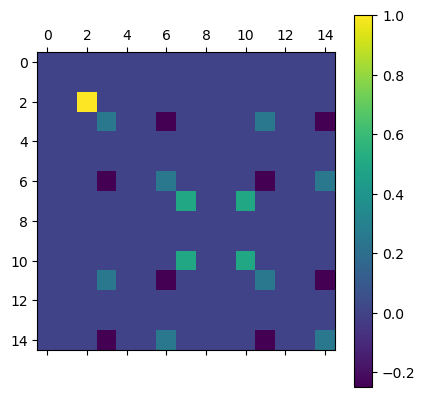

In [8]:
Pi = make_projector(germs[0], 8)
plt.matshow(Pi@Pi)
plt.colorbar()
print(np.linalg.matrix_rank(Pi))

In [9]:
# get the three eigenvectors asssociated with non-zero eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(Pi)
nonzero_eigenvalues = eigenvalues[np.abs(eigenvalues) > 1e-6]
nonzero_eigenvectors = eigenvectors[:, np.abs(eigenvalues) > 1e-6]

In [10]:
e0 = nonzero_eigenvectors[:, 0]
e1 = nonzero_eigenvectors[:, 1]
e2 = nonzero_eigenvectors[:, 2]

In [11]:
def lie_evec_to_pauli_basis(evec):
    return sum([pauli_basis_2q[idx+1]*e for idx, e in enumerate(evec)])

In [12]:
np.round(lie_evec_to_pauli_basis(e0), 3)

array([[-1.+0.j, -0.+0.j,  0.-0.j, -0.+0.j],
       [-0.-0.j,  1.+0.j,  0.-0.j, -0.-0.j],
       [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
       [-0.-0.j, -0.+0.j,  0.-0.j,  1.+0.j]])

In [13]:
np.round(lie_evec_to_pauli_basis(e1), 3)

array([[-0.015+0.j, -0.   -0.j,  0.   +0.j,  0.   -0.j],
       [-0.   +0.j, -0.985+0.j, -0.   -0.j, -1.   -0.j],
       [ 0.   -0.j, -0.   +0.j, -0.015+0.j,  0.   -0.j],
       [ 0.   +0.j, -1.   +0.j,  0.   +0.j,  1.015+0.j]])

In [14]:
np.round(lie_evec_to_pauli_basis(e2), 3)

array([[ 0.   +0.j   , -0.   +0.j   , -0.   -1.414j,  0.   +0.j   ],
       [-0.   -0.j   ,  0.006+0.j   , -0.   +0.j   ,  0.006+0.j   ],
       [-0.   +1.414j, -0.   -0.j   ,  0.   +0.j   ,  0.   +0.j   ],
       [ 0.   -0.j   ,  0.006+0.j   ,  0.   -0.j   , -0.007+0.j   ]])

In [15]:
H1 = lie_evec_to_pauli_basis(e0)
H2 = lie_evec_to_pauli_basis(e1)
H3 = lie_evec_to_pauli_basis(e2)
def check_unitary(u):
    return np.allclose(u@u.conj().T, np.eye(4))

def check_hermitian(H):
    return np.allclose(H, H.conj().T)

print(check_hermitian(H1))
print(check_hermitian(H2))
print(check_hermitian(H3))

True
True
True


In [16]:
def find_joint_diagonalizer_with_randomization(matrices):
    """
    Take a random linear combination of the matrices and
    find the joint diagonalizer of the resulting matrix.

    Then check that the diagonalizer is also a joint diagonalizer
    """
    n = len(matrices)
    v = np.random.randn(n) 
    v /= np.linalg.norm(v)
    M = sum([v[i]*matrices[i] for i in range(n)])
    evals, evecs = np.linalg.eig(M)
    P = evecs
    P_H = P.conj().T
    for i in range(n):
        # check that the off-diagonal elements are zero
        assert np.allclose(P_H @ matrices[i] @ P, np.diag(np.diag(P_H @ matrices[i] @ P)))
    return P

In [17]:
P = find_joint_diagonalizer_with_randomization([H1, H2, H3])
P_H = P.conj().T 

In [18]:
print(np.round(P, 3))

[[ 0.707+0.j     0.   -0.707j  0.   +0.j    -0.   +0.j   ]
 [ 0.   -0.j    -0.   -0.j    -0.383-0.j     0.924+0.j   ]
 [-0.   -0.707j  0.707+0.j    -0.   +0.j     0.   -0.j   ]
 [-0.   +0.j     0.   +0.j     0.924+0.j     0.383-0.j   ]]


In [19]:
np.round(P_H@H1@P, 3)

array([[-1.-0.j,  0.+0.j, -0.+0.j, -0.+0.j],
       [ 0.-0.j, -1.+0.j, -0.-0.j, -0.+0.j],
       [-0.-0.j, -0.+0.j,  1.+0.j, -0.-0.j],
       [-0.-0.j, -0.-0.j, -0.+0.j,  1.+0.j]])

In [20]:
np.round(P_H@H2@P, 3)

array([[-0.015-0.j,  0.   +0.j,  0.   -0.j, -0.   -0.j],
       [ 0.   -0.j, -0.015-0.j,  0.   -0.j,  0.   +0.j],
       [ 0.   +0.j,  0.   +0.j,  1.429-0.j,  0.   -0.j],
       [-0.   +0.j,  0.   -0.j,  0.   +0.j, -1.399+0.j]])

In [21]:
np.round(P_H@H3@P, 3)

array([[-1.414-0.j, -0.   -0.j, -0.   +0.j,  0.   -0.j],
       [-0.   +0.j,  1.415+0.j, -0.   +0.j, -0.   -0.j],
       [-0.   -0.j, -0.   -0.j, -0.009-0.j,  0.   +0.j],
       [ 0.   +0.j, -0.   +0.j,  0.   -0.j,  0.009-0.j]])

# Germ Optimization

We will consider all Clifford interleaving operators, and search for 5 germs whose projectors are all orthogonal

In [22]:
from itertools import product

def compile_pauli_string_1q_to_unitary(cstring):
    x = expm(-1j * np.pi/4 * SigX)
    y = expm(-1j * np.pi/4 * SigY)
    z = expm(-1j * np.pi/4 * SigZ)
    chars_in_cstring = list(cstring)
    unitary = np.eye(2)
    for c in chars_in_cstring:
        if c == 'I':
            pass
        elif c == 'X':
            unitary = x@unitary
        elif c == 'Y':
            unitary = y@unitary
        elif c == 'Z':
            unitary = z@unitary
        else:
            raise ValueError('Invalid character in clifford string')
    return unitary


def product_upto(iterable, max_length):
  """
  Generate all possible combinations of elements from the given iterable,
  with the length of each combination less than or equal to max_length.

  Args:
    iterable: An iterable from which to generate combinations.
    max_length: The maximum length of the combinations.

  Returns:
    A list of tuples representing the combinations.
  """
  result = []
  for length in range(1, max_length + 1):
    for combination in product(iterable, repeat=length):
      result.append(combination)
  return result

def product_upto(iterable, max_length):
  """
  Generate all possible combinations of elements from the given iterable,
  with the length of each combination less than or equal to max_length.

  Args:
    iterable: An iterable from which to generate combinations.
    max_length: The maximum length of the combinations.

  Returns:
    A list of tuples representing the combinations.
  """
  result = []
  for length in range(1, max_length + 1):
    for combination in product(iterable, repeat=length):
      result.append(combination)
  return result


def check_if_similar_clifford(u1, u2):
    # check if u1 and u2 are similar up to a global phase
    if np.allclose(u1, u2):
        return True
    elif np.allclose(u1, -u2):
        return True
    elif np.allclose(u1, 1j*u2):
        return True
    elif np.allclose(u1, -1j*u2):
        return True
    else:
        return False


def is_similar_in_list(string, list_of_strings):
    u = compile_pauli_string_1q_to_unitary(string)
    for s in list_of_strings:
        v = compile_pauli_string_1q_to_unitary(s)
        if check_if_similar_clifford(u, v):
            return True
    return False


def find_clifford_group_representation():
    all_strings = [('I', )] + product_upto('XYZ', 6)

    # now find a the unique strings until you have 24
    unique_strings = []
    for s in all_strings:
        if not is_similar_in_list(s, unique_strings):
            unique_strings.append(s)
        if len(unique_strings) == 24:
            break
    # convert the strings to a list of strings
    unique_strings = [''.join(s) for s in unique_strings]
    return unique_strings


In [23]:
clifford_group = find_clifford_group_representation()
clifford_group

['I',
 'X',
 'Y',
 'Z',
 'XX',
 'XY',
 'XZ',
 'YY',
 'YZ',
 'ZX',
 'ZZ',
 'XXX',
 'XXY',
 'XXZ',
 'XYY',
 'XZX',
 'XZZ',
 'YYY',
 'YYZ',
 'ZZZ',
 'XXXZ',
 'XXZX',
 'XYYZ',
 'XZZZ']

In [47]:
def pauli_string_to_germ_part(pauli_string, qid):
    """
    Convert a pauli string to a germ part
    """
    germ_part = []
    for c in pauli_string:
        if c == 'X':
            germ_part.append(f'X{qid}')
        elif c == 'Y':
            germ_part.append(f'Y{qid}')
        elif c == 'Z':
            germ_part.append(f'Z{qid}')
        elif c == 'I':
            pass
        else:
            raise ValueError(f'Invalid character {c} in clifford string')
    return germ_part

In [103]:
all_germs = []
for c1 in clifford_group:
    for c2 in clifford_group:
        all_germs.append(pauli_string_to_germ_part(c1, 1) + pauli_string_to_germ_part(c2, 2) + ['CZ'] )
        all_germs.append(pauli_string_to_germ_part(c1, 1) + pauli_string_to_germ_part(c2, 2))

In [164]:
all_pi_rotation_germs = []
for p1 in ['I', 'X', 'Y', 'Z']:
    for p2 in ['I', 'X', 'Y', 'Z']:
        for p3 in ['I', 'X', 'Y', 'Z']:
            for p4 in ['I', 'X', 'Y', 'Z']:
                g1 = pauli_string_to_germ_part(p1, 1)
                g2 = pauli_string_to_germ_part(p2, 2)
                g3 = pauli_string_to_germ_part(p3, 1)
                g4 = pauli_string_to_germ_part(p4, 2)
                all_pi_rotation_germs.append(g1*2 + g2*2 + ['CZ'] + g3*2 + g4*2 + ['CZ'])
                all_pi_rotation_germs.append(g1*2 + g2*2 + ['CZ'] + g3*2 + g4*2)

In [167]:
rank_3_germs = []
for g in all_pi_rotation_germs:
    Pi_g = make_projector_with_unkown_order(g)
    print(g, np.linalg.matrix_rank(Pi_g))
    if np.linalg.matrix_rank(Pi_g) == 3:
        rank_3_germs.append(g)


['CZ', 'CZ'] 15
['CZ'] 9
['CZ', 'X2', 'X2', 'CZ'] 7
['CZ', 'X2', 'X2'] 3
['CZ', 'Y2', 'Y2', 'CZ'] 7
['CZ', 'Y2', 'Y2'] 3
['CZ', 'Z2', 'Z2', 'CZ'] 7
['CZ', 'Z2', 'Z2'] 9
['CZ', 'X1', 'X1', 'CZ'] 7
['CZ', 'X1', 'X1'] 3
['CZ', 'X1', 'X1', 'X2', 'X2', 'CZ'] 7
['CZ', 'X1', 'X1', 'X2', 'X2'] 3
['CZ', 'X1', 'X1', 'Y2', 'Y2', 'CZ'] 7
['CZ', 'X1', 'X1', 'Y2', 'Y2'] 3
['CZ', 'X1', 'X1', 'Z2', 'Z2', 'CZ'] 7
['CZ', 'X1', 'X1', 'Z2', 'Z2'] 3
['CZ', 'Y1', 'Y1', 'CZ'] 7
['CZ', 'Y1', 'Y1'] 3
['CZ', 'Y1', 'Y1', 'X2', 'X2', 'CZ'] 7
['CZ', 'Y1', 'Y1', 'X2', 'X2'] 3
['CZ', 'Y1', 'Y1', 'Y2', 'Y2', 'CZ'] 7
['CZ', 'Y1', 'Y1', 'Y2', 'Y2'] 3
['CZ', 'Y1', 'Y1', 'Z2', 'Z2', 'CZ'] 7
['CZ', 'Y1', 'Y1', 'Z2', 'Z2'] 3
['CZ', 'Z1', 'Z1', 'CZ'] 7
['CZ', 'Z1', 'Z1'] 9
['CZ', 'Z1', 'Z1', 'X2', 'X2', 'CZ'] 7
['CZ', 'Z1', 'Z1', 'X2', 'X2'] 3
['CZ', 'Z1', 'Z1', 'Y2', 'Y2', 'CZ'] 7
['CZ', 'Z1', 'Z1', 'Y2', 'Y2'] 3
['CZ', 'Z1', 'Z1', 'Z2', 'Z2', 'CZ'] 7
['CZ', 'Z1', 'Z1', 'Z2', 'Z2'] 9
['X2', 'X2', 'CZ', 'CZ'] 7
['X2', 'X2',

In [168]:
rank_3_germs

[['CZ', 'X2', 'X2'],
 ['CZ', 'Y2', 'Y2'],
 ['CZ', 'X1', 'X1'],
 ['CZ', 'X1', 'X1', 'X2', 'X2'],
 ['CZ', 'X1', 'X1', 'Y2', 'Y2'],
 ['CZ', 'X1', 'X1', 'Z2', 'Z2'],
 ['CZ', 'Y1', 'Y1'],
 ['CZ', 'Y1', 'Y1', 'X2', 'X2'],
 ['CZ', 'Y1', 'Y1', 'Y2', 'Y2'],
 ['CZ', 'Y1', 'Y1', 'Z2', 'Z2'],
 ['CZ', 'Z1', 'Z1', 'X2', 'X2'],
 ['CZ', 'Z1', 'Z1', 'Y2', 'Y2'],
 ['X2', 'X2', 'CZ'],
 ['X2', 'X2', 'CZ', 'Z2', 'Z2'],
 ['X2', 'X2', 'CZ', 'X1', 'X1'],
 ['X2', 'X2', 'CZ', 'X1', 'X1', 'X2', 'X2'],
 ['X2', 'X2', 'CZ', 'X1', 'X1', 'Y2', 'Y2'],
 ['X2', 'X2', 'CZ', 'X1', 'X1', 'Z2', 'Z2'],
 ['X2', 'X2', 'CZ', 'Y1', 'Y1'],
 ['X2', 'X2', 'CZ', 'Y1', 'Y1', 'X2', 'X2'],
 ['X2', 'X2', 'CZ', 'Y1', 'Y1', 'Y2', 'Y2'],
 ['X2', 'X2', 'CZ', 'Y1', 'Y1', 'Z2', 'Z2'],
 ['X2', 'X2', 'CZ', 'Z1', 'Z1'],
 ['X2', 'X2', 'CZ', 'Z1', 'Z1', 'Z2', 'Z2'],
 ['Y2', 'Y2', 'CZ'],
 ['Y2', 'Y2', 'CZ', 'Z2', 'Z2'],
 ['Y2', 'Y2', 'CZ', 'X1', 'X1'],
 ['Y2', 'Y2', 'CZ', 'X1', 'X1', 'X2', 'X2'],
 ['Y2', 'Y2', 'CZ', 'X1', 'X1', 'Y2', 'Y2'],
 ['Y2',

In [171]:
germ = ['X1', 'X2', 'CZ', 'X1', 'X2']
Ad = make_Adjoint(['X1', 'X2', 'CZ'])
Pi = make_projector(germ, 8)

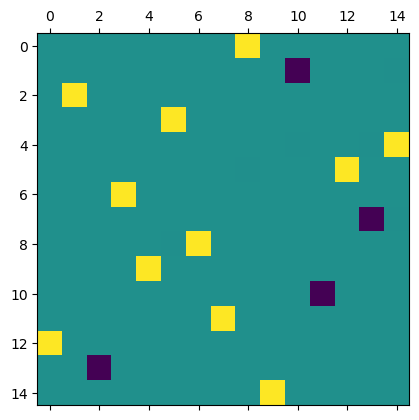

In [173]:
plt.matshow(Ad)

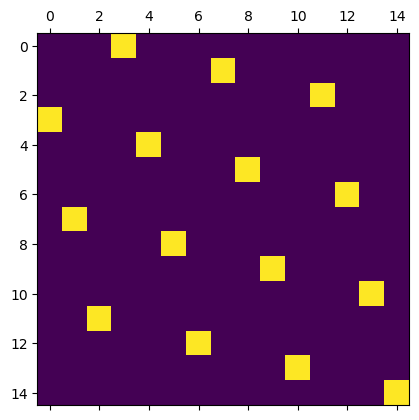

In [179]:
plt.matshow(Ad@Ad@Ad)

In [165]:
len(all_pi_rotation_germs)

512

In [107]:
def make_projector_with_unkown_order(germ, lie_basis=pauli_basis_2q[1:]):
    Ad = make_Adjoint(germ)
    # find the order of the adjoint as the first power of the adjoint that is the identity
    order = 1
    while not np.allclose(np.linalg.matrix_power(Ad, order), np.eye(15)):
        order += 1
    lops = [np.linalg.matrix_power(Ad, i) for i in range(order)]
    Pi = np.sum(lops, axis=0)/order
    if not np.allclose(Pi@Pi, Pi, atol=1e-6):
        print('not a projector')
    return Pi

In [108]:
# Construct projectors for each germ
all_projectors = []
for germ in tqdm(all_germs):
    Pi = make_projector_with_unkown_order(germ, 8)
    all_projectors.append(Pi)

  0%|          | 0/1152 [00:00<?, ?it/s]

100%|██████████| 1152/1152 [00:06<00:00, 186.36it/s]


In [109]:
def calculate_frame_potential(projectors):
    # the frame potential is the sum of the squared norms of the products of the projectors columns
    n = projectors[0].shape[0]
    m = len(projectors)
    frame_potential = 0
    for i in range(n):
        for j in range(n):
            for k in range(m):
                for l in range(m):
                    frame_potential += np.abs(projectors[k][:, i]@projectors[l][:, j])**2
    return frame_potential

def optimize_germs(initial_germs, germ_set, num_to_add):
    """
    Optimize the germs to minimize the frame potential
    """
    output_germs = initial_germs
    # initialize the projectors
    projectors = [make_projector_with_unkown_order(germ) for germ in initial_germs]
    # calculate the initial frame potential
    frame_potential = calculate_frame_potential(projectors)
    print(f'Initial frame potential: {frame_potential}')
    # optimize the germs by finidng the new one that minimizes the new frame potential
    for i in tqdm(range(num_to_add)):
        best_new_frame_potential = np.inf
        for germ in germ_set:
            if germ in output_germs:
                continue
            new_projectors = projectors + [make_projector_with_unkown_order(germ)]
            new_frame_potential = calculate_frame_potential(new_projectors)
            # we want to use the germ that minimizes the frame potential
            if new_frame_potential < best_new_frame_potential:
                best_new_frame_potential = new_frame_potential
                best_germ = germ
        # add the best germ to the output germs
        output_germs.append(best_germ)
        projectors = new_projectors
        frame_potential = best_new_frame_potential
        print(f'Frame potential after adding germ {i}: {frame_potential}')
    return output_germs

    

In [110]:
from tqdm import tqdm

In [111]:
best_germs = optimize_germs([['Y1', 'X2', 'X2', 'CZ']], all_germs, 3)

Initial frame potential: 3.0


 33%|███▎      | 1/3 [00:09<00:18,  9.32s/it]

Frame potential after adding germ 0: 6.0


 67%|██████▋   | 2/3 [00:22<00:11, 11.64s/it]

Frame potential after adding germ 1: 14.333333333333366


100%|██████████| 3/3 [00:41<00:00, 13.94s/it]

Frame potential after adding germ 2: 32.222222222221845


In [112]:
best_germs = optimize_germs([['Y1', 'X2', 'X2', 'CZ']], all_pi2_rotation_germs, 5)

Initial frame potential: 3.0


  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:02<00:08,  2.13s/it]

Frame potential after adding germ 0: 6.0


 40%|████      | 2/5 [00:05<00:07,  2.63s/it]

Frame potential after adding germ 1: 18.0


 60%|██████    | 3/5 [00:09<00:06,  3.37s/it]

Frame potential after adding germ 2: 44.625


 80%|████████  | 4/5 [00:15<00:04,  4.35s/it]

Frame potential after adding germ 3: 84.625


100%|██████████| 5/5 [00:22<00:00,  4.60s/it]

Frame potential after adding germ 4: 138.625


In [113]:
best_germs

[['Y1', 'X2', 'X2', 'CZ'],
 ['Z2', 'CZ', 'Y1', 'Z2', 'CZ'],
 ['Y1', 'Z2', 'CZ', 'Z2', 'CZ'],
 ['X2', 'CZ', 'X1', 'Z2', 'CZ'],
 ['X1', 'X2', 'CZ', 'X1', 'Z2', 'CZ'],
 ['X1', 'Z2', 'CZ', 'Y2', 'CZ']]

In [114]:
from tqdm import tqdm

In [115]:

def calculate_singularities(projectors):
    # measure how many dimensions are not spanned by the projectors
    sum_projectors = np.sum(projectors, axis=0)
    return 15-np.linalg.matrix_rank(sum_projectors, tol=1e-9)

def optimize_germs_for_singularities(initial_germs, germ_set):
    """
    Find the germs that minimize the number of singularities, search until there are none
    """
    output_germs = initial_germs
    # initialize the projectors
    projectors = [make_projector_with_unkown_order(germ) for germ in initial_germs]
    # calculate the initial frame potential
    singularities = calculate_singularities(projectors)
    print(f'Initial number of singularities: {singularities}')
    # optimize the germs by finidng the new one that minimizes the new frame potential
    while singularities > 0:
        best_new_singularities = np.inf
        for germ in germ_set:
            if germ in output_germs:
                continue
            new_projectors = projectors + [make_projector_with_unkown_order(germ)]
            new_singularities = calculate_singularities(new_projectors)
            # we want to use the germ that minimizes the frame potential
            if new_singularities < best_new_singularities:
                best_new_singularities = new_singularities
                best_germ = germ
        # add the best germ to the output germs
        output_germs.append(best_germ)
        projectors = new_projectors
        singularities = best_new_singularities
        print(f'Number of singularities after adding germ: {singularities}')
    return output_germs

In [116]:
filtered_germs = []
# pick out the germs whose projectors are rank 3
for germ in all_germs:
    Pi = make_projector_with_unkown_order(germ)
    if np.linalg.matrix_rank(Pi) == 3:
        filtered_germs.append(germ)

In [117]:
len(filtered_germs)

878

In [118]:
for germ in all_germs:
    rank = np.linalg.matrix_rank(make_projector_with_unkown_order(germ))
    if rank>3:
        print(germ, rank)
                                 

['CZ'] 9
[] 15
['X2'] 7
['Y2'] 7
['Z2', 'CZ'] 5
['Z2'] 7
['X2', 'X2'] 7
['X2', 'Y2'] 7
['X2', 'Z2'] 7
['Y2', 'Y2'] 7
['Y2', 'Z2'] 7
['Z2', 'X2'] 7
['Z2', 'Z2', 'CZ'] 9
['Z2', 'Z2'] 7
['X2', 'X2', 'X2'] 7
['X2', 'X2', 'Y2'] 7
['X2', 'X2', 'Z2'] 7
['X2', 'Y2', 'Y2'] 7
['X2', 'Z2', 'X2'] 7
['X2', 'Z2', 'Z2'] 7
['Y2', 'Y2', 'Y2'] 7
['Y2', 'Y2', 'Z2'] 7
['Z2', 'Z2', 'Z2', 'CZ'] 5
['Z2', 'Z2', 'Z2'] 7
['X2', 'X2', 'X2', 'Z2'] 7
['X2', 'X2', 'Z2', 'X2'] 7
['X2', 'Y2', 'Y2', 'Z2'] 7
['X2', 'Z2', 'Z2', 'Z2'] 7
['X1'] 7
['X1', 'X2'] 5
['X1', 'Y2'] 5
['X1', 'Z2'] 5
['X1', 'X2', 'X2', 'X2'] 5
['X1', 'Y2', 'Y2', 'Y2'] 5
['X1', 'Z2', 'Z2', 'Z2'] 5
['Y1'] 7
['Y1', 'X2'] 5
['Y1', 'Y2'] 5
['Y1', 'Z2'] 5
['Y1', 'X2', 'X2', 'X2'] 5
['Y1', 'Y2', 'Y2', 'Y2'] 5
['Y1', 'Z2', 'Z2', 'Z2'] 5
['Z1', 'CZ'] 5
['Z1'] 7
['Z1', 'X2'] 5
['Z1', 'Y2'] 5
['Z1', 'Z2', 'CZ'] 7
['Z1', 'Z2'] 5
['Z1', 'X2', 'X2', 'CZ'] 7
['Z1', 'X2', 'Y2', 'CZ'] 7
['Z1', 'X2', 'Z2', 'CZ'] 7
['Z1', 'Y2', 'Y2', 'CZ'] 7
['Z1', 'Y2', 'Z2', 'CZ'] 

In [119]:
optimize_germs_for_singularities([['Y1', 'X2', 'X2', 'CZ']], all_pi2_rotation_germs)

Initial number of singularities: 12
Number of singularities after adding germ: 0


[['Y1', 'X2', 'X2', 'CZ'], ['CZ', 'CZ']]

In [ ]:
best_germs

[['Y1', 'X2', 'X2', 'CZ'],
 ['X1', 'Z2', 'CZ'],
 ['X1', 'X1', 'Z2', 'Z2', 'CZ'],
 ['X1', 'X1', 'Z1', 'Z2', 'Z2', 'CZ'],
 ['Z1', 'Z1', 'X2', 'X2', 'Z2', 'CZ'],
 ['X1', 'Z1', 'Y2', 'Y2', 'Z2', 'CZ'],
 ['X1', 'Z1', 'Z2', 'Z2', 'CZ'],
 ['X1', 'Z1', 'Z2', 'Z2', 'Z2', 'CZ'],
 ['X1', 'X1', 'Z1', 'X1', 'Z2', 'CZ']]

In [ ]:
# calculate the rank of the sum of the projectors 
Pi_sum = sum([make_projector_with_unkown_order(germ) for germ in best_germs])
np.linalg.matrix_rank(Pi_sum)

13

In [123]:
germ = ['CZ']
Ad = make_Adjoint(germ)
Pi = make_projector_with_unkown_order(germ)

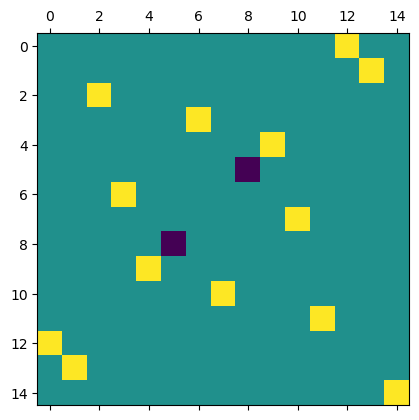

In [124]:
plt.matshow(Ad)

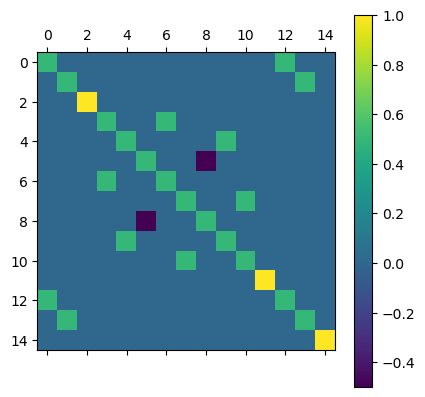

In [126]:
plt.matshow(Pi)
plt.colorbar()

In [133]:
np.linalg.matrix_rank(Pi)

9

In [134]:
np.linalg.eigvals(Pi)

array([ 1.00000000e+00,  5.55111512e-17,  1.00000000e+00, -1.11022302e-16,
        1.00000000e+00,  5.55111512e-17,  0.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  5.55111512e-17,  1.11022302e-16,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00])

In [143]:
nonzero_eigvecs = []
for eigval, eigvec in zip(*np.linalg.eig(Pi)):
    if np.abs(eigval) > 1e-6:
        nonzero_eigvecs.append(eigvec)

In [144]:
len(nonzero_eigvecs)

9

In [145]:
nonzero_eigvecs

[array([0.70710678, 0.70710678, 0.06676718, 0.23389656, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.70710678,
         0.70710678,  0.51239774, -0.16314345,  0.05602626,  0.70710678,
        -0.31153753,  0.00381042,  0.        ,  0.        ,  0.        ]),
 array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         5.62046729e-01, -1.78646011e-16, -3.47953380e-01,  3.09794084e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]),
 array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         4.32978028e-17, -4.32978028e-17,  4.87286929e-01,  6.88029226e-01,
        -2.36281034e-01,  1.06016971e-16,  2.96270167e-01, -1.

In [146]:
algebra_elements = []
for e in nonzero_eigvecs:
    algebra_elements.append(lie_evec_to_pauli_basis(e))

In [ ]:
algebra_elements   

[array([[ 0.06676718+0.j        ,  0.70710678-0.70710678j,
          0.23389656+0.j        ,  0.        +0.j        ],
        [ 0.70710678+0.70710678j, -0.06676718+0.j        ,
          0.        +0.j        ,  0.23389656+0.j        ],
        [ 0.23389656+0.j        ,  0.        +0.j        ,
          0.06676718+0.j        ,  0.70710678-0.70710678j],
        [ 0.        +0.j        ,  0.23389656+0.j        ,
          0.70710678+0.70710678j, -0.06676718+0.j        ]]),
 array([[ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
        [ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j],
        [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j]]),
 array([[ 3.81041761e-03+0.j        ,  0.00000000e+00+0.j        ,
          5.12397744e-01+0.47468097j,  1.11022302e-16-0.76313304j],
        [ 0.00000000e+00+0.j        ,  3.81041761e-03+0.j        ,
          1.41421356e+00+0.65108052j, -5.12397744e-01-0.14839408j],
        [ 5.12397744e-01-0.47468097j,  1.41421356e+00-0.65108052j,

In [156]:
def check_commutator(a, b):
    return np.allclose(a@b - b@a, np.zeros((4, 4)))

for idx1, a in enumerate(algebra_elements):
    for idx2, b in enumerate(algebra_elements):
        if idx1 != idx2:
            print(check_commutator(a, b), idx1, idx2)

False 0 1
False 0 2
False 0 3
False 0 4
False 0 5
False 0 6
False 0 7
False 0 8
False 1 0
False 1 2
False 1 3
False 1 4
False 1 5
False 1 6
False 1 7
False 1 8
False 2 0
False 2 1
False 2 3
False 2 4
False 2 5
False 2 6
False 2 7
False 2 8
False 3 0
False 3 1
False 3 2
False 3 4
True 3 5
False 3 6
False 3 7
False 3 8
False 4 0
False 4 1
False 4 2
False 4 3
False 4 5
False 4 6
False 4 7
False 4 8
False 5 0
False 5 1
False 5 2
True 5 3
False 5 4
False 5 6
False 5 7
False 5 8
False 6 0
False 6 1
False 6 2
False 6 3
False 6 4
False 6 5
False 6 7
False 6 8
False 7 0
False 7 1
False 7 2
False 7 3
False 7 4
False 7 5
False 7 6
False 7 8
False 8 0
False 8 1
False 8 2
False 8 3
False 8 4
False 8 5
False 8 6
False 8 7


In [160]:
CZ = model_CZ(np.zeros(15))
for a in algebra_elements:
    print(check_commutator(CZ, a))

False
False
False
False
False
False
False
False
True


# Projection on simulated idle 

In [180]:
sclifford_2q = []
for c1 in clifford_group:
    for c2 in clifford_group:
        g1 = pauli_string_to_germ_part(c1, 1)
        g2 = pauli_string_to_germ_part(c2, 2)
        sclifford_2q.append(g1 + g2)

In [ ]:
all_projection_operators = [make_projector_with_unkown_order(germ) for germ in sclifford_2q]


15
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
5
5
5
3
3
3
3
3
3
3
5
3
3
3
3
3
5
3
5
3
3
3
3
7
5
5
5
3
3
3
3
3
3
3
5
3
3
3
3
3
5
3
5
3
3
3
3
7
5
5
5
3
3
3
3
3
3
3
5
3
3
3
3
3
5
3
5
3
3
3
3
7
3
3
3
7
3
3
7
3
3
7
3
7
7
7
7
7
3
7
3
3
3
3
3
7
3
3
3
3
5
5
3
5
5
3
3
3
3
3
3
3
3
3
3
5
5
5
5
7
3
3
3
3
5
5
3
5
5
3
3
3
3
3
3
3
3
3
3
5
5
5
5
7
3
3
3
7
3
3
7
3
3
7
3
7
7
7
7
7
3
7
3
3
3
3
3
7
3
3
3
3
5
5
3
5
5
3
3
3
3
3
3
3
3
3
3
5
5
5
5
7
3
3
3
3
5
5
3
5
5
3
3
3
3
3
3
3
3
3
3
5
5
5
5
7
3
3
3
7
3
3
7
3
3
7
3
7
7
7
7
7
3
7
3
3
3
3
3
7
5
5
5
3
3
3
3
3
3
3
5
3
3
3
3
3
5
3
5
3
3
3
3
7
3
3
3
7
3
3
7
3
3
7
3
7
7
7
7
7
3
7
3
3
3
3
3
7
3
3
3
7
3
3
7
3
3
7
3
7
7
7
7
7
3
7
3
3
3
3
3
7
3
3
3
7
3
3
7
3
3
7
3
7
7
7
7
7
3
7
3
3
3
3
3
7
3
3
3
7
3
3
7
3
3
7
3
7
7
7
7
7
3
7
3
3
3
3
3
7
3
3
3
7
3
3
7
3
3
7
3
7
7
7
7
7
3
7
3
3
3
3
3
7
5
5
5
3
3
3
3
3
3
3
5
3
3
3
3
3
5
3
5
3
3
3
3
7
3
3
3
7
3
3
7
3
3
7
3
7
7
7
7
7
3
7
3
3
3
3
3
7
5
5
5
3
3
3
3
3
3
3
5
3
3
3
3
3
5
3
5
3
3
3
3
7
3
3
3
3
5
5
3
5
5
3
3
3
3
3
3
3
3
3
3

In [203]:
proj_cz = make_projector_with_unkown_order(['CZ'])
np.linalg.matrix_rank(proj_cz)

9

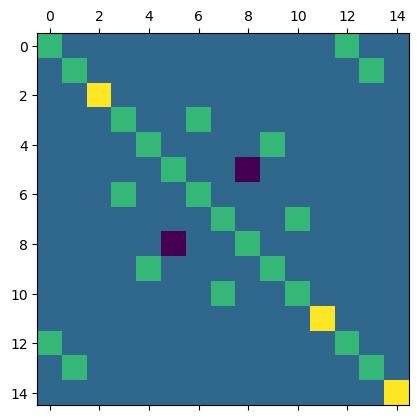

In [204]:
plt.matshow(proj_cz)

In [187]:
for idx, p in enumerate(all_projection_operators):
    print(np.linalg.matrix_rank(p), sclifford_2q[idx])

15 []
7 ['X2']
7 ['Y2']
7 ['Z2']
7 ['X2', 'X2']
7 ['X2', 'Y2']
7 ['X2', 'Z2']
7 ['Y2', 'Y2']
7 ['Y2', 'Z2']
7 ['Z2', 'X2']
7 ['Z2', 'Z2']
7 ['X2', 'X2', 'X2']
7 ['X2', 'X2', 'Y2']
7 ['X2', 'X2', 'Z2']
7 ['X2', 'Y2', 'Y2']
7 ['X2', 'Z2', 'X2']
7 ['X2', 'Z2', 'Z2']
7 ['Y2', 'Y2', 'Y2']
7 ['Y2', 'Y2', 'Z2']
7 ['Z2', 'Z2', 'Z2']
7 ['X2', 'X2', 'X2', 'Z2']
7 ['X2', 'X2', 'Z2', 'X2']
7 ['X2', 'Y2', 'Y2', 'Z2']
7 ['X2', 'Z2', 'Z2', 'Z2']
7 ['X1']
5 ['X1', 'X2']
5 ['X1', 'Y2']
5 ['X1', 'Z2']
3 ['X1', 'X2', 'X2']
3 ['X1', 'X2', 'Y2']
3 ['X1', 'X2', 'Z2']
3 ['X1', 'Y2', 'Y2']
3 ['X1', 'Y2', 'Z2']
3 ['X1', 'Z2', 'X2']
3 ['X1', 'Z2', 'Z2']
5 ['X1', 'X2', 'X2', 'X2']
3 ['X1', 'X2', 'X2', 'Y2']
3 ['X1', 'X2', 'X2', 'Z2']
3 ['X1', 'X2', 'Y2', 'Y2']
3 ['X1', 'X2', 'Z2', 'X2']
3 ['X1', 'X2', 'Z2', 'Z2']
5 ['X1', 'Y2', 'Y2', 'Y2']
3 ['X1', 'Y2', 'Y2', 'Z2']
5 ['X1', 'Z2', 'Z2', 'Z2']
3 ['X1', 'X2', 'X2', 'X2', 'Z2']
3 ['X1', 'X2', 'X2', 'Z2', 'X2']
3 ['X1', 'X2', 'Y2', 'Y2', 'Z2']
3 ['X1', 'X2', 'Z2', '

In [188]:
rank_3_projectors = [p for p in all_projection_operators if np.linalg.matrix_rank(p) == 3]

In [189]:
len(rank_3_projectors)

348

In [ ]:
# find a set of projectors that span the lie algebra
def find_spanning_set(projectors):
    n = len(projectors)
    spanning_set = []
    for i in range(n):
        spanning_set.append(projectors[i])
        if np.linalg.matrix_rank(np.array(spanning_set)) == 15:
            break
    return spanning_set

In [201]:
np.linalg.eigvals(sum(rank_3_projectors))

array([155.11334439,  82.        , 110.88665561, 155.11334439,
       110.88665561,  82.        ,  67.90582297,  18.66666667,
        50.        ,  49.61225752,  37.41122931,  35.14858617,
        25.92210402,  25.92210402,  37.41122931])

In [199]:
# find a set of projectors with rank 15 that minimizes the frame potential
def find_best_germs(rank_3_projectors, max_itrs=5):
    best_frame_potential = np.inf
    proj_set = [rank_3_projectors[0]]
    for idx in tqdm(range(max_itrs)):
        best_frame_potential = np.inf
        for proj in rank_3_projectors:
            new_proj_set = proj_set + [proj]
            frame_potential = calculate_frame_potential(new_proj_set)
            if frame_potential < best_frame_potential:
                best_frame_potential = frame_potential
                best_proj = proj
        proj_set.append(best_proj)
        print(f'Frame potential after adding germ {idx}: {best_frame_potential}')
        print(f'Rank of the sum of projectors: {np.linalg.matrix_rank(np.sum(proj_set, axis=0))}')
        if np.linalg.matrix_rank(np.sum(proj_set)) == 15:
            break
    return proj_set

In [200]:
find_best_germs(rank_3_projectors)

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:01<00:04,  1.00s/it]

Frame potential after adding germ 0: 5.999999999999997
Rank of the sum of projectors: 6


 40%|████      | 2/5 [00:03<00:05,  1.69s/it]

Frame potential after adding germ 1: 8.999999999999998
Rank of the sum of projectors: 9


 60%|██████    | 3/5 [00:06<00:05,  2.62s/it]

Frame potential after adding germ 2: 15.999999999999982
Rank of the sum of projectors: 10


 80%|████████  | 4/5 [00:12<00:03,  3.88s/it]

Frame potential after adding germ 3: 22.999999999999982
Rank of the sum of projectors: 11


100%|██████████| 5/5 [00:21<00:00,  4.26s/it]

Frame potential after adding germ 4: 30.888888888888857
Rank of the sum of projectors: 12


[array([[ 1.00000000e+000,  0.00000000e+000,  0.00000000e+000,
          9.24446373e-033,  0.00000000e+000, -1.54074396e-033,
          0.00000000e+000,  0.00000000e+000, -1.89911355e-065,
          0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
          3.79822710e-065,  0.00000000e+000,  0.00000000e+000],
        [ 0.00000000e+000,  0.00000000e+000, -1.57009246e-016,
          0.00000000e+000,  3.42113883e-049,  0.00000000e+000,
          0.00000000e+000, -2.34083818e-097,  0.00000000e+000,
         -9.67644186e-049, -2.05268330e-048,  2.10843959e-081,
          0.00000000e+000, -2.90293256e-048,  2.05268330e-048],
        [ 0.00000000e+000,  1.57009246e-016,  0.00000000e+000,
          0.00000000e+000, -5.69734065e-065,  0.00000000e+000,
          0.00000000e+000, -2.14002601e-097,  0.00000000e+000,
          2.05268330e-048, -9.67644186e-049,  2.14002601e-097,
          0.00000000e+000, -2.05268330e-048, -2.90293256e-048],
        [ 9.24446373e-033,  0.00000000e+000,  0.0000

In [209]:
def make_Adjoint(conjugating_operation, lie_basis=pauli_basis_2q[1:]):
    lop = np.zeros((len(lie_basis), len(lie_basis)), dtype=complex)
    for i, op in enumerate(lie_basis):
        for j, op in enumerate(lie_basis):
            lop[i, j] = np.trace(lie_basis[i] @ conjugating_operation @ lie_basis[j] @ np.linalg.inv(conjugating_operation))/4
    return lop.real

def make_projector(conjugating_operation, order, lie_basis=pauli_basis_2q[1:]):
    Ad = make_Adjoint(conjugating_operation)
    lops = [np.linalg.matrix_power(Ad, i) for i in range(order)]
    Pi = np.sum(lops, axis=0)/order
    if not np.allclose(Pi@Pi, Pi, atol=1e-6):
        print('not a projector')
    return Pi


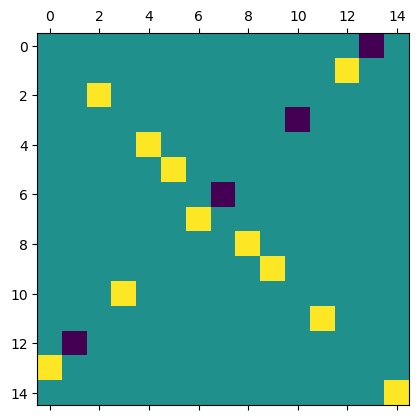

In [210]:
pauli_ZZ = np.kron(SigZ, SigZ)
Ad = make_Adjoint(expm(-1j*np.pi/4*pauli_ZZ))
plt.matshow(Ad)

In [219]:
Pi = make_projector(expm(-1j*np.pi/8*pauli_ZZ), 8)

In [220]:
np.linalg.matrix_rank(Pi)

7

In [ ]:
make_projector()

# Signal Estimation

In [ ]:
def construct_model_to_experimental_matrix(P, H1, H2, H3, subspace_convention=((0, 1), (1, 2), (2, 3))):
    """
    Construct the matrix that transforms the model phases to the experimental phases
    """
    P_H = P.conj().T
    h1 = np.diag(P_H@H1@P)
    h2 = np.diag(P_H@H2@P)
    h3 = np.diag(P_H@H3@P)
    a1 = subspace_convention[0][0]
    b1 = subspace_convention[0][1]
    a2 = subspace_convention[1][0]
    b2 = subspace_convention[1][1]
    a3 = subspace_convention[2][0]
    b3 = subspace_convention[2][1]
    print(np.round(h1, 3), '\n', np.round(h2, 3), '\n', np.round(h3, 3))
    M = np.array([
        [h1[a1] - h1[b1], h2[a1] - h2[b1], h3[a1] - h3[b1]],
        [h1[a2] - h1[b2], h2[a2] - h2[b2], h3[a2] - h3[b2]],
        [h1[a3] - h1[b3], h2[a3] - h2[b3], h3[a3] - h3[b3]]
    ])
    # check that the matrix is real
    assert np.allclose(np.imag(M), 0)
    return M.real
    

In [ ]:
M = construct_model_to_experimental_matrix(P, H1, H2, H3)

[-1.+0.j -1.-0.j  1.+0.j  1.+0.j] 
 [-0.015-0.j -0.015-0.j  1.429+0.j -1.399+0.j] 
 [ 1.415-0.j -1.414-0.j -0.009-0.j  0.009+0.j]


In [ ]:
np.round(M, 3)

array([[ 0.   , -0.   ,  2.828],
       [-2.   , -1.444, -1.405],
       [ 0.   ,  2.828, -0.018]])

In [ ]:
germs[0]

['Y1', 'CZ']

In [ ]:
germ_unitary = model.compile_unitary(germs[0], xvec)
Psi = P
plus_01 = np.array([1, 1, 0, 0])/np.sqrt(2)
plus_12 = np.array([0, 1, 1, 0])/np.sqrt(2)
plus_23 = np.array([0, 0, 1, 1])/np.sqrt(2)
right_01 = np.array([1, 1j, 0, 0])/np.sqrt(2)
right_12 = np.array([0, 1, 1j, 0])/np.sqrt(2)
right_23 = np.array([0, 0, 1, 1j])/np.sqrt(2)
probs01_inphase = lambda k: np.abs(plus_01.T@Psi.conj().T@matrix_power(germ_unitary, k)@Psi@plus_01)**2
probs01_quad = lambda k: np.abs(plus_01.T@Psi.conj().T@matrix_power(germ_unitary, k)@Psi@right_01)**2
probs12_inphase = lambda k: np.abs(plus_12.T@Psi.conj().T@matrix_power(germ_unitary, k)@Psi@plus_12)**2
probs12_quad = lambda k: np.abs(plus_12.T@Psi.conj().T@matrix_power(germ_unitary, k)@Psi@right_12)**2
probs23_inphase = lambda k: np.abs(plus_23@Psi.conj().T@matrix_power(germ_unitary, k)@Psi@plus_23)**2
probs23_quad = lambda k: np.abs(plus_23@Psi.conj().T@matrix_power(germ_unitary, k)@Psi@right_23)**2

In [ ]:
def estimate_phase(x, germ, Psi, subspace_label, k):
    """
    Estimate the phase of the germ with the complex logarithm for one application
    """
    u_noisy = model.compile_unitary(germ, x)
    prep_inphase = np.zeros(4, dtype=complex)
    prep_inphase[subspace_label[0]] = 1/np.sqrt(2)
    prep_inphase[subspace_label[1]] = 1/np.sqrt(2)
    prep_quad = np.zeros(4, dtype=complex)
    prep_quad[subspace_label[0]] = 1/np.sqrt(2)
    prep_quad[subspace_label[1]] = 1j/np.sqrt(2)
    probs_inphase = np.abs(prep_inphase@Psi.conj().T@matrix_power(u_noisy, k)@Psi@prep_inphase)**2
    probs_quad = np.abs(prep_inphase@Psi.conj().T@matrix_power(u_noisy, k)@Psi@prep_quad)**2
    s_inphase = 1 - 2*probs_inphase
    s_quad = 1 - 2*probs_quad
    signal = -s_inphase  -1j*s_quad
    return np.angle(signal)

In [ ]:
psi01 = estimate_phase(xvec, germs[0], Psi, (0, 1), 8)
psi12 = estimate_phase(xvec, germs[0], Psi, (1, 2), 8)
psi23 = estimate_phase(xvec, germs[0], Psi, (2, 3), 8)
print(psi01, psi12, psi23)

-0.03719234242817827 0.009307590272481977 -0.03899131415223612


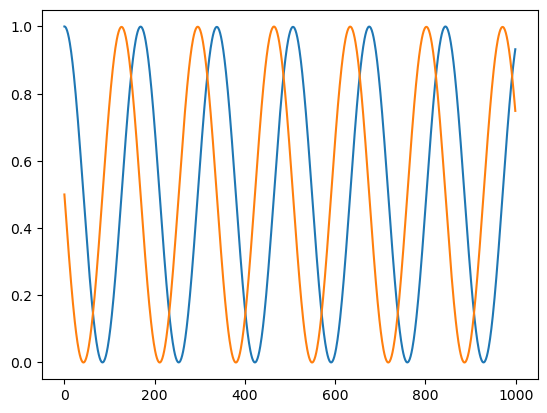

In [ ]:
plt.plot([probs01_inphase(k*8) for k in range(1000)])
plt.plot([probs01_quad(k*8) for k in range(1000)])

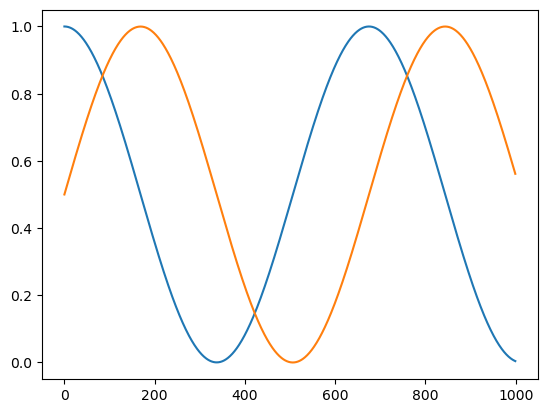

In [ ]:
plt.plot([probs12_inphase(k*8) for k in range(1000)])
plt.plot([probs12_quad(k*8) for k in range(1000)])


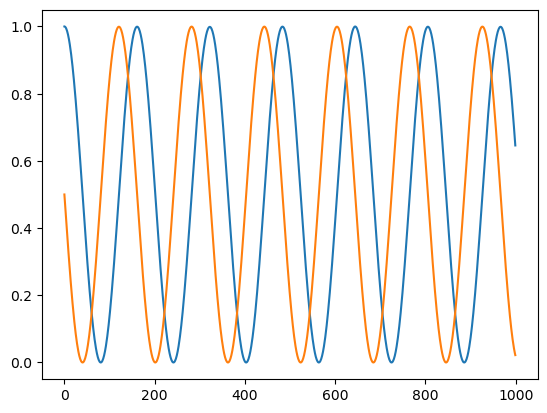

In [ ]:
plt.plot([probs23_inphase(k*8) for k in range(1000)])
plt.plot([probs23_quad(k*8) for k in range(1000)])